In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init
from torch.optim import lr_scheduler
import torch.utils.data
#import torchvision.transforms as transforms


In [2]:
#Utils
def display3DObject(test_object):   
    print("Displaying the object")
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.voxels(test_object, edgecolor='k')
    plt.show()
    
def addNoise(shape, noise=0.1):
    #print(shape)
    return Variable(torch.zeros(shape).normal_(0, noise).cuda())

In [3]:
batch_size = 5


images = np.load('padded_gray_chair_imgs.npy')
images[:] = (images[:] - np.mean(images[:])) / np.std(images[:])
voxels = np.load('chair_voxels.npy')
print(images[1:1316].shape)
print(images[1316:1416].shape)
train_images = images[1:1316]
val_images = images[1316:1416]
train_voxels = voxels[1:1316]
val_voxels = voxels[1316:1416]

(1315, 128, 128)
(100, 128, 128)


Displaying the object


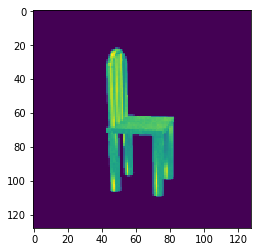

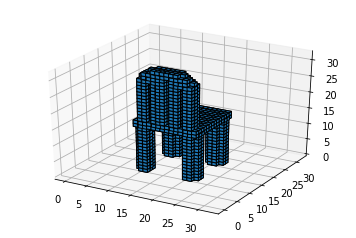

In [4]:
display_id = 56

train_data = [train_voxels, train_images]
for _ in range(len(train_data)):
    train_data[_] = torch.from_numpy(train_data[_]).type(torch.FloatTensor)
    train_data[_] = train_data[_].cuda()
train_data = [(train_data[0][i], train_data[1][i]) for i in range(len(train_data[0]))] 
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True, drop_last=True)
plt.imshow(train_images[display_id])
display3DObject(train_voxels[display_id])

Displaying the object


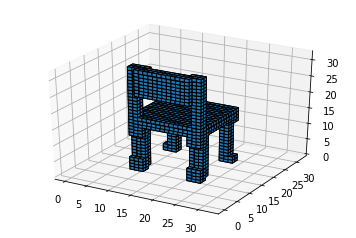

In [5]:
display3DObject(voxels[877])

In [6]:
class VAE(nn.Module):
    def __init__(self, input_nc=1, z_size=200, ndf=25, cube_size=32):
        super(VAE, self).__init__()
        self.encoderLayer1 = torch.nn.Sequential(
            torch.nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf),
            torch.nn.ReLU()
        )
        
        self.encoderLayer2 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*2),
            torch.nn.ReLU()
        )
        
        self.encoderLayer3 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*4),
            torch.nn.ReLU()
        )
        
        self.encoderLayer4 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1),
            torch.nn.BatchNorm2d(ndf*8),
            torch.nn.ReLU()
        )
        
        self.encoderLayer5 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*8, ndf*8, kernel_size=4, stride=4, padding=1),
            torch.nn.BatchNorm2d(ndf*8),
            torch.nn.ReLU()
        )
        
        self.encoderLayer6 = torch.nn.Sequential(
            torch.nn.Conv2d(ndf*8, ndf*8, kernel_size=4, stride=2, padding=1),
            torch.nn.Tanh()
        )
        
        self.z_size = z_size
        self.cube_size = cube_size
        
        self.fc1 = nn.Linear(ndf*8, self.z_size)
        self.fc2 = nn.Linear(ndf*8, self.z_size)
        
        self.decoderLayer1 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.z_size, self.cube_size*4, kernel_size=4, stride=2, padding=(0,0,0)),
            torch.nn.BatchNorm3d(self.cube_size*4),
            torch.nn.ReLU()
        )
        
        self.decoderLayer2 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size*4, self.cube_size*2, kernel_size=4, stride=2, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_size*2),
            torch.nn.ReLU()
        )
        self.decoderLayer3 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size*2, self.cube_size*1, kernel_size=4, stride=2, padding=(1, 1, 1)),
            torch.nn.BatchNorm3d(self.cube_size*1),
            torch.nn.ReLU()
        )

        self.decoderLayer4 = torch.nn.Sequential(
            torch.nn.ConvTranspose3d(self.cube_size, 1, kernel_size=4, stride=2,  padding=(1, 1, 1)),
            torch.nn.Sigmoid()
        )
        
    def encoder(self, x): 
        out = self.encoderLayer1(x)
        out = self.encoderLayer2(out)
        out = self.encoderLayer3(out)
        out = self.encoderLayer4(out)
        out = self.encoderLayer5(out)
        out = self.encoderLayer6(out).view(-1, self.z_size)
        return self.fc1(out), self.fc2(out)
    
    #source: https://github.com/bhpfelix/Variational-Autoencoder-PyTorch/blob/master/src/vanila_vae.py
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.cuda.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def decoder(self, x):
        out = self.decoderLayer1(x)
        out = self.decoderLayer2(out)
        out = self.decoderLayer3(out)
        out = self.decoderLayer4(out)
        return out
    
    def forward(self, x):
        mu, sigma = self.encoder(x)
        latent = self.reparametrize(mu,sigma)
        latent = latent.view(-1,self.z_size,1,1,1)#latent.unsqueeze(2).unsqueeze(2).unsqueeze(2)
        
        object_3D = self.decoder(latent)
        return object_3D
        

In [7]:
vae = VAE().cuda()

In [8]:
lr_vae = 0.0025
lr_d = 0.001
adam_beta_vae = (0.5, 0.5)
adam_beta_d = (0.5, 0.5)
vae_solver = optim.Adam(vae.parameters(), lr=lr_vae, betas = adam_beta_vae)

In [9]:
#Training the system
num_epochs = 500
val_images = torch.FloatTensor(val_images)
val_voxels = torch.FloatTensor(val_voxels)
loss = nn.BCELoss()
for epoch in range(num_epochs):
    vae_losses = []
    for batch_idx, (data3d, data2d) in enumerate(train_loader):
        var_3D_data = Variable(data3d).cuda().float()
        var_2D_data = Variable(data2d).cuda().float().unsqueeze(1)
        generated_object = vae(var_2D_data).squeeze()
        loss_ = loss(generated_object, var_3D_data)
        vae.zero_grad()
        loss_.backward()
        vae_solver.step()
        vae_losses.append(loss_)
    val_3D_data = Variable(val_voxels).cuda().float()
    val_2D_data = Variable(val_images).cuda().float().unsqueeze(1)
    generated_object_val = torch.round(vae(val_2D_data).squeeze())
    accuracy = np.mean((generated_object_val  == val_3D_data).squeeze().data.cpu().numpy())
    vae_losses_mean = np.mean(np.concatenate(vae_losses))
    print("Epoch: ", epoch, '\n', "VAE loss: ", vae_losses_mean.data.cpu().numpy()[0])
    print("Accuracy", accuracy)

Epoch:  0 
 VAE loss:  0.17644891
Accuracy 0.9274981689453125
Epoch:  1 
 VAE loss:  0.14695469
Accuracy 0.9274981689453125
Epoch:  2 
 VAE loss:  0.1368658
Accuracy 0.9297833251953125
Epoch:  3 
 VAE loss:  0.13101783
Accuracy 0.9388165283203125
Epoch:  4 
 VAE loss:  0.12756908
Accuracy 0.9386785888671875
Epoch:  5 
 VAE loss:  0.123469815
Accuracy 0.9410958862304688
Epoch:  6 
 VAE loss:  0.12178273
Accuracy 0.9414794921875
Epoch:  7 
 VAE loss:  0.119408466
Accuracy 0.9371273803710938
Epoch:  8 
 VAE loss:  0.11692678
Accuracy 0.9401766967773437
Epoch:  9 
 VAE loss:  0.1143418
Accuracy 0.9442120361328125
Epoch:  10 
 VAE loss:  0.11340032
Accuracy 0.941524658203125
Epoch:  11 
 VAE loss:  0.11274248
Accuracy 0.9426882934570312
Epoch:  12 
 VAE loss:  0.111101165
Accuracy 0.939952392578125
Epoch:  13 
 VAE loss:  0.10984737
Accuracy 0.9436965942382812
Epoch:  14 
 VAE loss:  0.10893069
Accuracy 0.9454403686523437
Epoch:  15 
 VAE loss:  0.107486494
Accuracy 0.9416970825195312
Epoch

Epoch:  131 
 VAE loss:  0.046732586
Accuracy 0.942833251953125
Epoch:  132 
 VAE loss:  0.04654615
Accuracy 0.943763427734375
Epoch:  133 
 VAE loss:  0.046228927
Accuracy 0.9440899658203125
Epoch:  134 
 VAE loss:  0.04608781
Accuracy 0.9440899658203125
Epoch:  135 
 VAE loss:  0.04603644
Accuracy 0.9439642333984375
Epoch:  136 
 VAE loss:  0.04549152
Accuracy 0.9430209350585937
Epoch:  137 
 VAE loss:  0.045350816
Accuracy 0.9435784912109375
Epoch:  138 
 VAE loss:  0.04484314
Accuracy 0.9425653076171875
Epoch:  139 
 VAE loss:  0.045006856
Accuracy 0.9428488159179688
Epoch:  140 
 VAE loss:  0.0439934
Accuracy 0.943524169921875
Epoch:  141 
 VAE loss:  0.044035546
Accuracy 0.9433169555664063
Epoch:  142 
 VAE loss:  0.043698434
Accuracy 0.9428125
Epoch:  143 
 VAE loss:  0.043598432
Accuracy 0.944300537109375
Epoch:  144 
 VAE loss:  0.043873977
Accuracy 0.9430715942382812
Epoch:  145 
 VAE loss:  0.042971935
Accuracy 0.9426419067382813
Epoch:  146 
 VAE loss:  0.042746678
Accuracy

Epoch:  259 
 VAE loss:  0.022538785
Accuracy 0.9407162475585937
Epoch:  260 
 VAE loss:  0.022501443
Accuracy 0.9406219482421875
Epoch:  261 
 VAE loss:  0.022327378
Accuracy 0.9417990112304687
Epoch:  262 
 VAE loss:  0.022043599
Accuracy 0.9416989135742188
Epoch:  263 
 VAE loss:  0.02208815
Accuracy 0.9403494262695312
Epoch:  264 
 VAE loss:  0.02205173
Accuracy 0.9408920288085938
Epoch:  265 
 VAE loss:  0.02215997
Accuracy 0.9413925170898437
Epoch:  266 
 VAE loss:  0.021713313
Accuracy 0.9424612426757812
Epoch:  267 
 VAE loss:  0.021447793
Accuracy 0.9401177978515625
Epoch:  268 
 VAE loss:  0.02166345
Accuracy 0.94055419921875
Epoch:  269 
 VAE loss:  0.021422083
Accuracy 0.941082763671875
Epoch:  270 
 VAE loss:  0.021181908
Accuracy 0.9414898681640625
Epoch:  271 
 VAE loss:  0.021396816
Accuracy 0.9423196411132813
Epoch:  272 
 VAE loss:  0.021041457
Accuracy 0.9418655395507812
Epoch:  273 
 VAE loss:  0.021120291
Accuracy 0.9405563354492188
Epoch:  274 
 VAE loss:  0.02094

Epoch:  387 
 VAE loss:  0.011960129
Accuracy 0.9408493041992188
Epoch:  388 
 VAE loss:  0.011851169
Accuracy 0.9396368408203125
Epoch:  389 
 VAE loss:  0.011943401
Accuracy 0.9409970092773438
Epoch:  390 
 VAE loss:  0.011880686
Accuracy 0.9409893798828125
Epoch:  391 
 VAE loss:  0.011632504
Accuracy 0.9403506469726562
Epoch:  392 
 VAE loss:  0.011703593
Accuracy 0.9423382568359375
Epoch:  393 
 VAE loss:  0.011882625
Accuracy 0.9412161254882813
Epoch:  394 
 VAE loss:  0.011655597
Accuracy 0.9413320922851562
Epoch:  395 
 VAE loss:  0.011554198
Accuracy 0.940919189453125
Epoch:  396 
 VAE loss:  0.011270228
Accuracy 0.9401473999023438
Epoch:  397 
 VAE loss:  0.011253017
Accuracy 0.941636962890625
Epoch:  398 
 VAE loss:  0.011400232
Accuracy 0.9403341674804687
Epoch:  399 
 VAE loss:  0.011385167
Accuracy 0.9406137084960937
Epoch:  400 
 VAE loss:  0.011325138
Accuracy 0.940238037109375
Epoch:  401 
 VAE loss:  0.011028296
Accuracy 0.9405807495117188
Epoch:  402 
 VAE loss:  0.0

37
Real Image
torch.Size([1, 1, 128, 128])
torch.Size([32, 32, 32])
Displaying the object


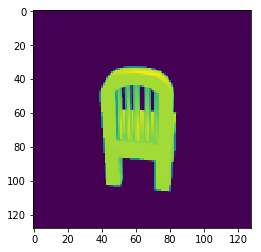

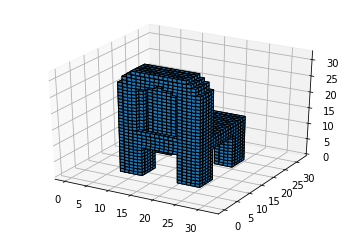

Predicted 3D object
Displaying the object


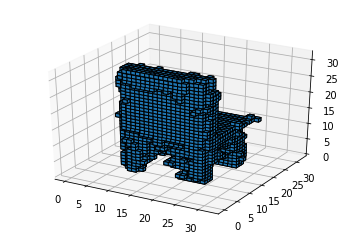

70
Real Image
torch.Size([1, 1, 128, 128])
torch.Size([32, 32, 32])
Displaying the object


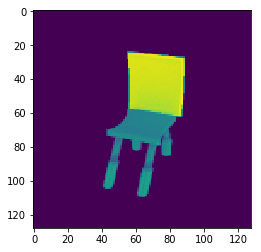

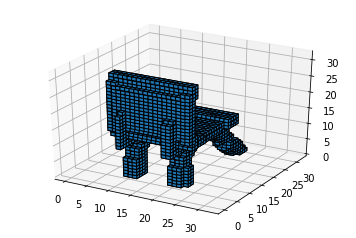

Predicted 3D object
Displaying the object


In [ ]:
# Generate the 3D Object 
#Testing the general Structure of the VAE
import random
for j in range(0,2):
    i = random.randint(0,99)
    print(i)
    test_image = Variable(torch.FloatTensor(val_images[i])).view(1,1,128,128).cuda()
    print("Real Image")
    plt.imshow(test_image.squeeze().data.cpu().numpy())
    print(test_image.shape)
    test_object = vae(test_image).squeeze().data.cpu().numpy()
    #print("Real 3D voxels")
    print(val_voxels[i].shape)
    display3DObject(Variable(val_voxels[i]).data.cpu().numpy())
    print("Predicted 3D object")
    display3DObject(test_object >0.5)
    

In [ ]:
torch.save(vae.state_dict(), 'vae_000125.pt')

In [ ]:
#Testing the general Structure of the VAE
test_image = Variable(torch.FloatTensor(images[6])).view(1,1,128,128).cuda()
print(test_image.shape)
vae(test_image)